In [1]:
# https://www.kaggle.com/datasets/gspmoreira/articles-sharing-reading-from-cit-deskdrop?resource=download

import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('../../..')
from uncertain.utils.data import Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation import test_vanilla, test_uncertain

from uncertain.implicit.base import MF
from uncertain.implicit.DoubleMF import AUR, Pointwise, Pairwise

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_table('users_interactions.csv', sep=',', header=0)
    data = data[['personId', 'contentId', 'timestamp']].rename(columns={'personId': 'user', 'contentId': 'item', 'timestamp': 'timestamps'})
    data = data.drop_duplicates(subset=['user', 'item'])

    data = Data(data, min_user_len=6, min_item_len=5, implicit=True)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=5)

data.item_support = data.item_support.astype(float)
data.user_support = data.user_support.astype(float)        

base_batch_size = 1024
trials = 10 ## 0 for eval only mode
patience = 2 ## Number of validation checks before ending training

Data prepared: 1021 users, 2109 items.
24026 train, 5531 validation and 6873 test interactions.


# Base MF models

In [4]:
name = 'MF-MSE'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='MSE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2, log=True),
              'n_negatives': trial.suggest_int('neg', 2, 50)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfmse = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfmse, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
5,5,0.072085,2023-01-13 12:46:56.225626,2023-01-13 12:54:08.620343,0 days 00:07:12.394717,47,0.000839,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.993372,COMPLETE
2,2,0.069097,2023-01-13 12:31:35.292709,2023-01-13 12:36:28.969999,0 days 00:04:53.677290,27,0.000239,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.991277,COMPLETE
9,9,0.068709,2023-01-13 13:10:59.599406,2023-01-13 13:18:06.640016,0 days 00:07:07.040610,35,0.003216,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.991932,COMPLETE
3,3,0.067745,2023-01-13 12:36:28.970758,2023-01-13 12:42:05.275188,0 days 00:05:36.304430,37,0.000513,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.992773,COMPLETE
1,1,0.065593,2023-01-13 12:26:26.825980,2023-01-13 12:31:35.292161,0 days 00:05:08.466181,41,0.000607,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.993952,COMPLETE
7,7,0.058818,2023-01-13 12:59:13.750355,2023-01-13 13:08:34.920357,0 days 00:09:21.170002,41,0.000206,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.993180,COMPLETE
4,4,0.058155,2023-01-13 12:42:05.275967,2023-01-13 12:46:56.224827,0 days 00:04:50.948860,50,0.007142,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.992773,COMPLETE
6,6,0.057263,2023-01-13 12:54:08.621163,2023-01-13 12:59:13.749409,0 days 00:05:05.128246,47,0.008245,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.992464,COMPLETE
8,8,0.038585,2023-01-13 13:08:34.921303,2023-01-13 13:10:59.597905,0 days 00:02:24.676602,3,0.003654,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.971375,COMPLETE
0,0,0.025043,2023-01-13 12:25:06.102598,2023-01-13 12:26:26.825340,0 days 00:01:20.722742,5,0.000171,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.973989,COMPLETE


In [5]:
name = 'MF-Pointwise'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='Pointwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2, log=True),
              'n_negatives': trial.suggest_int('neg', 2, 50)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfpoint = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfpoint, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
2,2,0.046234,2023-01-13 13:28:36.933329,2023-01-13 13:32:41.526581,0 days 00:04:04.593252,24,0.008122,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.927923,COMPLETE
6,6,0.045737,2023-01-13 13:41:51.142250,2023-01-13 13:46:34.917539,0 days 00:04:43.775289,45,0.000702,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.963741,COMPLETE
1,1,0.045567,2023-01-13 13:22:21.555270,2023-01-13 13:28:36.932478,0 days 00:06:15.377208,49,0.000438,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.965364,COMPLETE
5,5,0.044910,2023-01-13 13:37:43.245842,2023-01-13 13:41:51.141628,0 days 00:04:07.895786,34,0.000716,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.951393,COMPLETE
7,7,0.043474,2023-01-13 13:46:34.918414,2023-01-13 13:50:41.533706,0 days 00:04:06.615292,30,0.002138,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.944719,COMPLETE
9,9,0.043324,2023-01-13 13:52:49.639603,2023-01-13 13:56:20.240390,0 days 00:03:30.600787,35,0.007610,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.945931,COMPLETE
3,3,0.041967,2023-01-13 13:32:41.527483,2023-01-13 13:37:13.706677,0 days 00:04:32.179194,40,0.000206,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.958639,COMPLETE
0,0,0.040846,2023-01-13 13:18:07.460681,2023-01-13 13:22:21.554371,0 days 00:04:14.093690,32,0.002542,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.947300,COMPLETE
8,8,0.034845,2023-01-13 13:50:41.534472,2023-01-13 13:52:49.638947,0 days 00:02:08.104475,8,0.006643,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.837814,COMPLETE
4,4,0.005743,2023-01-13 13:37:13.707573,2023-01-13 13:37:43.244920,0 days 00:00:29.537347,6,0.000297,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.511892,COMPLETE


In [2]:
name = 'MF-Pairwise'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='Pairwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-4, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=1)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfpair = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfpair, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_wd,user_attrs_filename,user_attrs_mean_loss,state
19,19,0.008597,2023-01-13 16:05:44.341606,2023-01-13 16:05:59.125588,0 days 00:00:14.783982,1.949003e-03,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.509956,COMPLETE
2,2,0.007270,2023-01-13 13:56:48.202014,2023-01-13 13:57:03.607431,0 days 00:00:15.405417,8.605098e-03,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.512512,COMPLETE
6,6,0.007029,2023-01-13 13:57:42.657680,2023-01-13 13:58:02.157416,0 days 00:00:19.499736,1.744226e-03,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.517289,COMPLETE
1,1,0.006844,2023-01-13 13:56:36.443247,2023-01-13 13:56:48.201116,0 days 00:00:11.757869,1.633983e-04,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.508273,COMPLETE
7,7,0.006842,2023-01-13 13:58:02.158425,2023-01-13 13:58:25.997533,0 days 00:00:23.839108,1.002992e-03,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.523393,COMPLETE
18,18,0.006792,2023-01-13 15:52:40.876634,2023-01-13 15:53:09.630786,0 days 00:00:28.754152,5.304818e-04,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.592434,COMPLETE
9,9,0.006322,2023-01-13 13:58:42.024380,2023-01-13 13:59:02.563677,0 days 00:00:20.539297,5.578753e-04,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.516429,COMPLETE
14,14,0.005607,2023-01-13 15:48:47.970443,2023-01-13 15:49:03.459194,0 days 00:00:15.488751,3.301963e-04,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.562099,COMPLETE
11,11,0.005526,2023-01-13 15:02:03.852052,2023-01-13 15:02:45.429181,0 days 00:00:41.577129,2.888363e-03,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.522532,COMPLETE
8,8,0.005516,2023-01-13 13:58:25.998318,2023-01-13 13:58:42.023339,0 days 00:00:16.025021,4.891839e-03,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.512638,COMPLETE


# Uncertainty MF models

In [ ]:
name = 'AUR'
def init_model(**kwargs):
    return AUR(baseline=mfmse, embedding_dim=128, beta=1/2, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 20, 100),
              'gamma': trial.suggest_float('gamma', 1e-4, 1e-2, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.8, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size * 5 / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

In [ ]:
name = 'Pointwise'
def init_model(**kwargs):
    return MF_GPR(baseline=mfgpr, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 20, 100),
              'gamma': trial.suggest_float('gamma', 1e-4, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size * 5 / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

In [ ]:
name = 'Pairwise'
def init_model(**kwargs):
    return Binary(baseline=mfgpr, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'gamma': trial.suggest_float('gamma', 1e-4, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

# MF

In [2]:
name = 'MF-BCE2'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='BCE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'lr': trial.suggest_float('lr', 1e-5, 1e-4),
              'weight_decay': trial.suggest_float('wd', 1e-3, 1e-3),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    model = init_model(**params)
    print(model.weight_decay_user, model.n_negatives)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=2)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mfbce = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfbce, data, max_k=10, name=name)

clear_output(wait=True)
print(results['Recall'])
best_runs

[0.00166775 0.00296589 0.00462548 0.00644287 0.00748061 0.00785558
 0.00923858 0.00956505 0.00957308 0.00998454]


,number,value,datetime_start,datetime_complete,duration,params_lr,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
1,1,0.004337,2023-01-05 02:28:33.039901,2023-01-05 02:28:48.316744,0 days 00:00:15.276843,0.000070,5,0.001,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.523742,COMPLETE
0,0,0.003927,2023-01-05 02:28:14.869336,2023-01-05 02:28:33.039113,0 days 00:00:18.169777,0.000073,4,0.001,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.520504,COMPLETE


In [3]:
name = 'MF-BPR'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, loss='BPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mfbpr = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfbpr, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.00887311 0.01109139 0.01316178 0.01434487 0.01547619 0.01555013
 0.01567689 0.0157878  0.01628076 0.01672441]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
2,2,0.037416,2023-01-02 15:59:45.035982,2023-01-02 16:00:15.125341,0 days 00:00:30.089359,256,128,0.000099,0.000050,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.037013,2023-01-02 16:02:01.082590,2023-01-02 16:02:14.609122,0 days 00:00:13.526532,256,128,0.000998,0.000061,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.035852,2023-01-02 16:00:15.126360,2023-01-02 16:00:39.186346,0 days 00:00:24.059986,256,128,0.000197,0.000087,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
1,1,0.035522,2023-01-02 15:59:12.721707,2023-01-02 15:59:45.035242,0 days 00:00:32.313535,256,128,0.000212,0.000024,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
4,4,0.034770,2023-01-02 16:00:39.187234,2023-01-02 16:00:59.037966,0 days 00:00:19.850732,256,128,0.000739,0.000024,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


# DoubleMF

[0.00266193 0.00488021 0.00813369 0.009021   0.00958296 0.00993789
 0.01019141 0.01045267 0.01052661 0.01070407]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
8,8,0.039604,2023-01-03 17:39:31.247732,2023-01-03 17:41:24.901141,0 days 00:01:53.653409,256,128,0.000055,16,7.488093e-05,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.036823,2023-01-03 17:37:22.093978,2023-01-03 17:37:44.080506,0 days 00:00:21.986528,256,128,0.000246,14,8.392313e-08,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
1,1,0.036769,2023-01-03 17:37:06.339008,2023-01-03 17:37:15.783495,0 days 00:00:09.444487,256,128,0.000680,2,4.909398e-05,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
9,9,0.036276,2023-01-03 17:41:24.901876,2023-01-03 17:41:41.682329,0 days 00:00:16.780453,256,128,0.000471,16,9.146834e-05,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
4,4,0.035902,2023-01-03 17:37:44.081284,2023-01-03 17:38:18.839466,0 days 00:00:34.758182,256,128,0.000157,11,8.210100e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


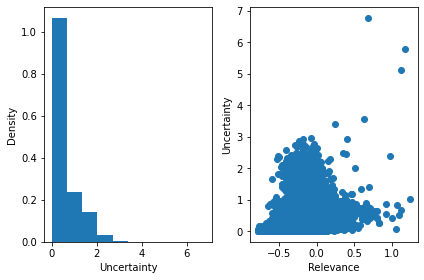

In [2]:
name = 'DoubleMF-Pointwise'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, loss='GBR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.00621118 0.00887311 0.00961254 0.01049985 0.01187519 0.01252588
 0.01252588 0.01263679 0.01293257 0.01299172]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
2,2,0.032697,2023-01-03 17:42:19.604588,2023-01-03 17:42:51.952869,0 days 00:00:32.348281,256,128,0.000118,0.000063,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
1,1,0.032234,2023-01-03 17:42:00.011976,2023-01-03 17:42:19.603851,0 days 00:00:19.591875,256,128,0.000327,0.000048,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.031970,2023-01-03 17:44:19.495686,2023-01-03 17:44:39.217741,0 days 00:00:19.722055,256,128,0.000392,0.000056,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
0,0,0.031684,2023-01-03 17:41:45.541441,2023-01-03 17:42:00.011370,0 days 00:00:14.469929,256,128,0.000539,0.000057,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
5,5,0.027581,2023-01-03 17:43:38.137428,2023-01-03 17:43:49.569124,0 days 00:00:11.431696,256,128,0.000947,0.000020,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


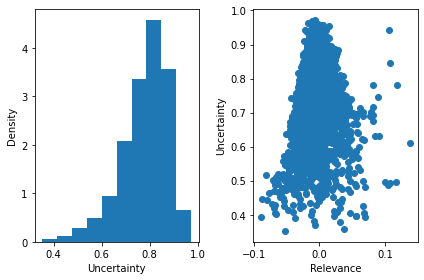

In [3]:
name = 'DoubleMF-Pairwise'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, loss='GPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.00443656 0.00665484 0.00754215 0.00887311 0.00947205 0.00947205
 0.00989035 0.01044492 0.01076745 0.01072309]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
2,2,0.052239,2023-01-03 17:46:19.280462,2023-01-03 17:46:59.990274,0 days 00:00:40.709812,256,128,0.000555,5,0.000058,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
5,5,0.051109,2023-01-03 17:49:15.752952,2023-01-03 17:50:01.195976,0 days 00:00:45.443024,256,128,0.000717,7,0.000011,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
9,9,0.050651,2023-01-03 17:52:03.099833,2023-01-03 17:52:35.353583,0 days 00:00:32.253750,256,128,0.000846,16,0.000019,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
4,4,0.049911,2023-01-03 17:48:24.245277,2023-01-03 17:49:15.752027,0 days 00:00:51.506750,256,128,0.000466,18,0.000036,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.047964,2023-01-03 17:51:22.063108,2023-01-03 17:52:03.099047,0 days 00:00:41.035939,256,128,0.000474,20,0.000037,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


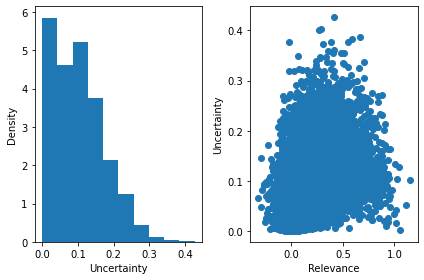

In [4]:
name = 'DoubleMF-MSE'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, loss='AUR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

# Results

In [15]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
    order = ['MF-BCE', 'MF-BPR', 'MLP-BCE', 'MLP-BPR', 'GaussianMLP-Pointwise', 'GaussianMLP-Pairwise', 'GaussianMLP-AUR']
# order = ['MF', 'MF-NUS', 'MF-NIS', 'MF-ENSEMBLE', 'MLP', 'MLP-NUS', 'MLP-NIS', 'MLP-ENSEMBLE', 'MCDropout', 'BayesianMLP', 'GER', 'CPMF']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r', 'm']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*', 'p']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}

# Results
results[['FCP', 'URI', 'UAC']].T

,MF-BCE,MF-BPR,MLP-BCE,MLP-BPR,GaussianMLP-Pointwise,GaussianMLP-Pairwise,GaussianMLP-AUR
FCP,0.294168,0.299327,0.322969,0.325405,0.305345,0.313655,0.330993
URI,NaN,NaN,NaN,NaN,0.161354,0.220749,0.153879
UAC,NaN,NaN,NaN,NaN,-0.001021,-0.065162,0.016132


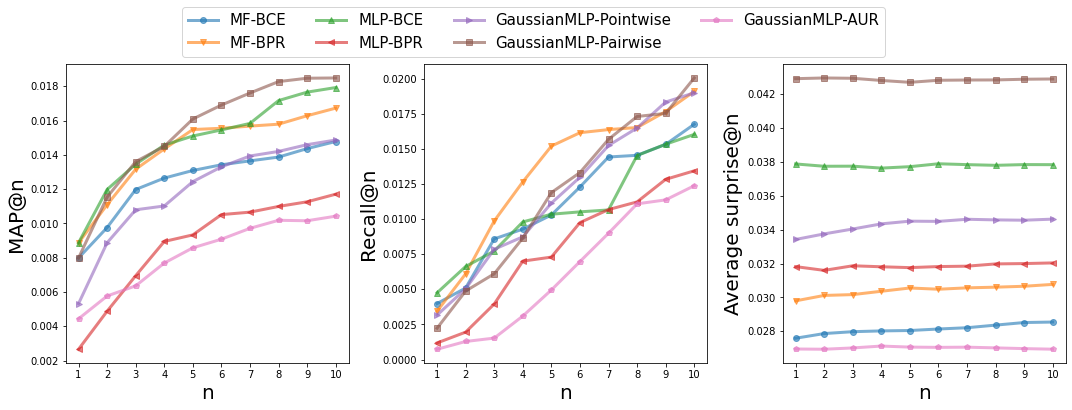

In [17]:
## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(15, 5), ncols=3, sharex=True)
for index, row in results.iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 11), row['Average_Surprise'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
ax[2].set_xlabel('n', fontsize=20)
ax[2].set_ylabel('Average surprise@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=4, bbox_to_anchor=(0.83, 1.15))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches='tight')

In [18]:
## Difference between vanilla predictions and uncertainty predictions (for those that perform it)
models = ['MF-BPR', 'MF-BCE', 'MLP-BCE', 'MLP-BPR']
metrics = ['MAP', 'MAP2', 'Recall', 'Recall2', 'Average_Surprise', 'Average_Surprise2']
results.drop(index=models)[metrics].transform(lambda x: x.str[-1])

,MAP,MAP2,Recall,Recall2,Average_Surprise,Average_Surprise2
GaussianMLP-Pointwise,0.014865,0.014775,0.019015,0.018934,0.034620,0.033948
GaussianMLP-Pairwise,0.018484,0.018758,0.020073,0.019363,0.042886,0.042806
GaussianMLP-AUR,0.010422,0.012027,0.012389,0.013701,0.026949,0.031178


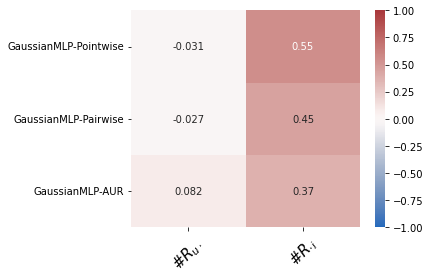

In [19]:
# Correlation plot
corr = results.drop(index=['MF-BCE', 'MF-BPR', 'MLP-BCE', 'MLP-BPR'])[['corr_usup', 'corr_isup']]
corr.columns=[r'#$R_{u\cdot}$', r'#$R_{\cdot i}$']
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

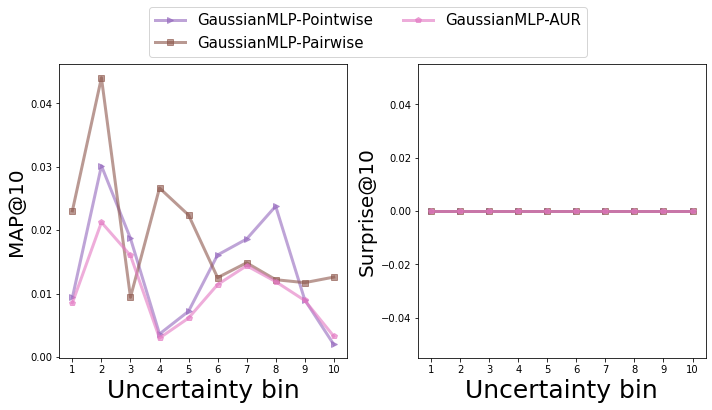

In [21]:
## MAP and Surprise vs Uncertainty
f, ax = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
x = np.arange(10) + 1
for index, row in results.drop(index=['MF-BCE', 'MF-BPR', 'MLP-BCE', 'MLP-BPR']).iterrows():
    ax[0].plot(x, row['MAP-Uncertainty'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(x, row['Surprise-Uncertainty'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set(xticks = x)
ax[0].set_xlabel('Uncertainty bin', fontsize=25)
ax[0].set_ylabel('MAP@10', fontsize=20)
ax[1].set_xlabel(r'Uncertainty bin', fontsize=25)
ax[1].set_ylabel('Surprise@10', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=2, bbox_to_anchor=(0.83, 1.15))
f.tight_layout()
f.savefig('plots/MAP-Uncertainty.pdf')

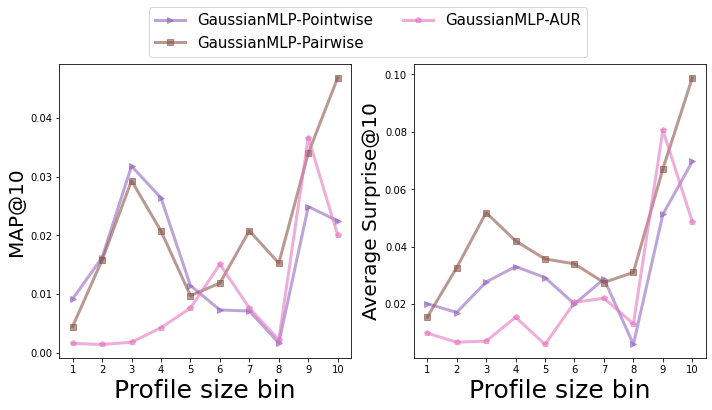

In [22]:
## MAP and Uncertainty vs Profile size
f, ax = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
for index, row in results.drop(index=['MF-BCE', 'MF-BPR', 'MLP-BCE', 'MLP-BPR']).iterrows():
    ax[0].plot(x, row['MAP-ProfSize'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(x, row['Surprise-ProfSize'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set(xticks = x)
ax[0].set_xlabel('Profile size bin', fontsize=25)
ax[0].set_ylabel('MAP@10', fontsize=20)
ax[1].set_ylabel('Average Surprise@10', fontsize=20)
ax[1].set_xlabel('Profile size bin', fontsize=25)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=2, bbox_to_anchor=(0.83, 1.15))
f.tight_layout()
f.savefig('plots/MAP-ProfSize.pdf')

GaussianMLP-Pointwise    8
GaussianMLP-Pairwise     0
GaussianMLP-AUR          0
Name: unc_MAP, dtype: int64


array([ 0.6, -1. , -1. ])

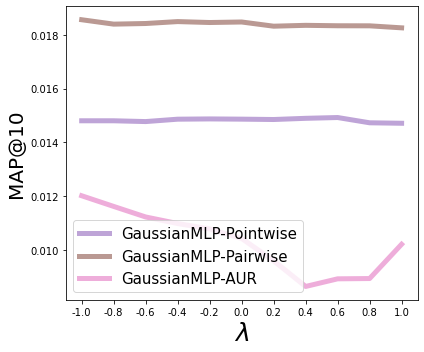

In [23]:
## MAP vs Coverage
f, ax = plt.subplots(figsize=(6, 5))
x = np.linspace(-1, 1, 11)
for index, row in results.drop(index=['MF-BCE', 'MF-BPR', 'MLP-BCE', 'MLP-BPR']).iterrows():
    ax.plot(x, row['unc_MAP'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax.set(xticks = x, xticklabels = [str(round(x, 1)) for x in x])
ax.set_xlabel(r'$\lambda$', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy_lambda.pdf')
idx = results.drop(index=['MF-BPR', 'MF-BCE', 'MLP-BCE', 'MLP-BPR'])['unc_MAP'].transform(np.argmax); print(idx)
x[idx]